In [1]:
# Capstone: Forecasting the number of antidiabetic drug prescriptions in Australia (using SARIMA)
# Purpose: To gauge the production of antidiabetic drugs, such as to produce enough to meet the demand and also 
# avoid overproduction

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [3]:
# Antidiabetic drug prescriptions in Australia, from 1991 to 2008
df = pd.read_csv("data/AusAntidiabeticDrug.csv")

In [4]:
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [5]:
df.describe()

,y
count,204.000000
mean,10.694430
std,5.956998
min,2.814520
25%,5.844095
50%,9.319345
75%,14.289964
max,29.665356


In [6]:
# Decompose the series using STL function. The period is equal to the frequency m.
# Since we have monthly data, the period is 12

decomposition = STL(df['y'], period=12).fit()

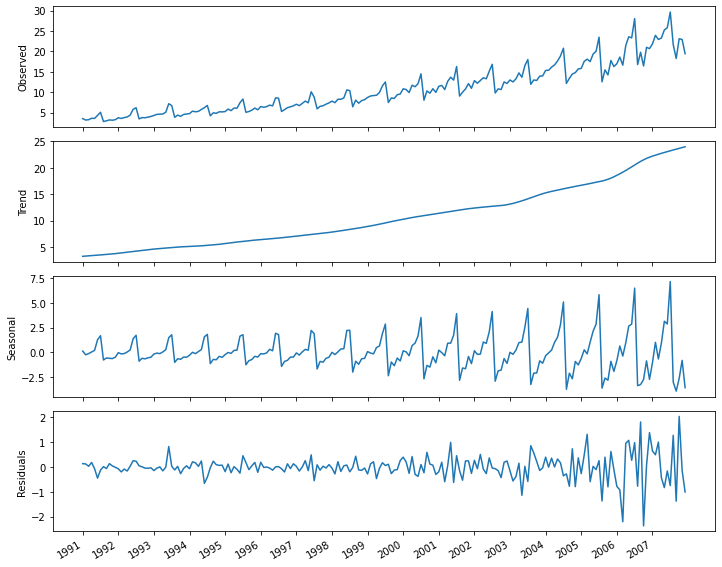

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 203, 12), np.arange(1991, 2008))

fig.autofmt_xdate()
plt.tight_layout()

In [8]:
# First model the dataset using an ARIMA(p, d, q) model
# Test for stationarity using augumented Dickey Fuller Algorithm

adf_result = adfuller(df['y'])

print(f'ADF Statistic:{adf_result[0]}')
print(f'p-value:{adf_result[1]}')

ADF Statistic:3.1451856893067376
p-value:1.0


In [9]:
# The process isn't stationery(p-value is greater than 0.05, ADF is positive), 
# so apply differentiation to make it stationery 

df_diff = np.diff(df['y'], n=1)

In [10]:
adf_result = adfuller(df_diff)

print(f'ADF Statistic:{adf_result[0]}')
print(f'p-value:{adf_result[1]}')

ADF Statistic:-2.4951721474496718
p-value:0.11665341686470432


In [11]:
# The process is still NOT stationery (p-value is still greater than 0.05), so apply differentiation again
df_diff2 = np.diff(df_diff, n=1)

In [12]:
adf_result = adfuller(df_diff2)

print(f'ADF Statistic:{adf_result[0]}')
print(f'p-value:{adf_result[1]}')

ADF Statistic:-10.29230470651752
p-value:3.543916358525336e-18


In [13]:
# We have ap-value smaller than 0.05 and a large negative ADF statistic, our series is stationary
# d = 2 (Number of rounds of differencing to make our data stationery)
d = 2

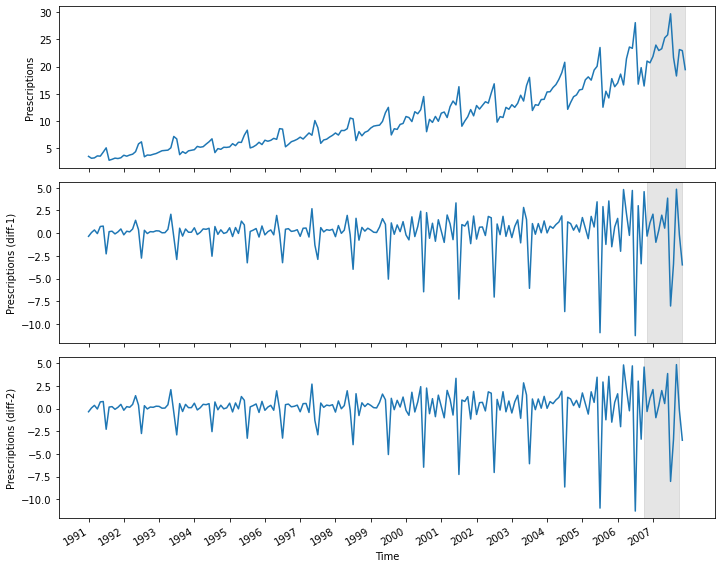

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(df['y'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Prescriptions')
ax1.axvspan(191, 203, color="#808080", alpha=0.2)

ax2.plot(df_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Prescriptions (diff-1)')
ax2.axvspan(190, 202, color="#808080", alpha=0.2)

ax3.plot(df_diff)
ax3.set_xlabel('Time')
ax3.set_ylabel('Prescriptions (diff-2)')
ax3.axvspan(189, 201, color="#808080", alpha=0.2)

plt.xticks(np.arange(0, 203, 12), np.arange(1991, 2008, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [15]:
# Define a list of possible values for p and q

from itertools import product

# Allow p and q to vary from 0 to 12 in order to capture seasonal information
ps = range(0, 13, 1)
qs = range(0, 13, 1)

# Set P and Q to 0, because we are working with ARIMA(p,d,q) model
Ps = [0]
Qs = [0]

# D is set to 0 because we are working with ARIMA(p,d,q) model
D = 0 

# s/m denote frequency
s = 12

# Generate all possible combinations of (p,d,q)(0,0,0)

ARIMA_order_list = list(product(ps, qs, Ps, Qs))
#print(ARIMA_order_list)

In [16]:
# use optimize_SARIMAX function to fit the many ARIMA(p,d,q) models
# SARIMA is a special kind of SARIMAX and ARIMA is a special kind of SARIMA

from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s:int) -> pd.DataFrame:
    results =[]
    
    # Iterate over each unique(p,q) combination. The use of tqdm will display a progress bar
    for order in tqdm(order_list):
        try:
            # Fit an ARIMA(p, d, q) model using SARIMAX function
            # We specify simple_differencing=False, to prevent differencing.
            # We also specify disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog,
                           order=(order[0], d, order[1]),
                           seasonal_order = (order[2], D, order[3], s),
                           simple_differencing=False).fit(disp=False)
        except:
            continue
        
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
# Run the optimize_SARIMA function to obtain the model with the lowest AIC.
# Use the last 36 months of the dataset as a test set to allow for rolling forecasts

import warnings
warnings.filterwarnings('ignore')

train = df['y'][:-36].copy()
test = df['y'][-36:].copy()

ARIMA_result_df = optimize_SARIMAX(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(11, 11, 0, 0)",345.499794
1,"(11, 1, 0, 0)",346.941737
2,"(11, 10, 0, 0)",347.200369
3,"(11, 2, 0, 0)",348.418968
4,"(11, 3, 0, 0)",348.849125
...,...,...
164,"(4, 0, 0, 0)",691.292339
165,"(3, 0, 0, 0)",700.076399
166,"(2, 0, 0, 0)",714.332006
167,"(1, 0, 0, 0)",746.349555


In [18]:
# From the returned DataFrame, a SARIMA(11,2,11)(0,0,0)12 model seems to be the most suitable, so fit it on the training set
# Note a SARIMA(11,2,11)(0,0,0) is equivalent to ARIMA(11,2,11)

ARIMA_model = SARIMAX(train, order=(11,2,11), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False) 

residuals = ARIMA_model_fit.resid

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  168
Model:             SARIMAX(11, 2, 11)   Log Likelihood                -149.750
Date:                Tue, 24 Oct 2023   AIC                            345.500
Time:                        12:18:36   BIC                            417.076
Sample:                             0   HQIC                           374.553
                                - 168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9854      0.031    -32.128      0.000      -1.046      -0.925
ar.L2         -0.9967      0.036    -27.445      0.000      -1.068      -0.925
ar.L3         -0.9879      0.047    -21.130      0.0

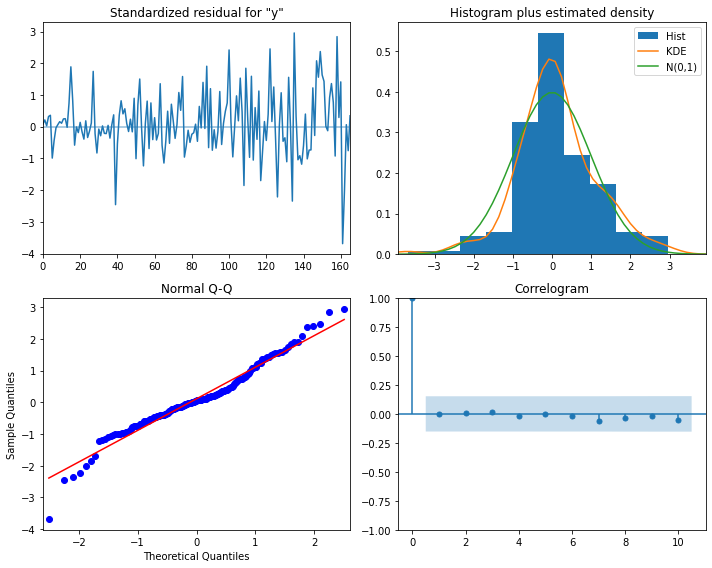

In [19]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8))

plt.tight_layout()

In [20]:
# From the the top-left plot, the variance is not constant, which is a discrepancy in comparison to white noise. 
# At the top right is the distribution of the residuals, we can see what is close to a normal distribution. 
# The Q-Q plot displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. 
# Finally, the correlogram at the bottom right, shows no significant coefficients after lag 0, just like white noise.

# Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, 
# as it means that the model’s errors are random.

In [21]:
# Next run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated

from statsmodels.stats.diagnostic import acorr_ljungbox

pvalues = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)
pvalues.columns = ['stat', 'p-value']
pvalues

,stat,p-value
1,1.591394,0.207127
2,1.640010,0.440429
3,1.792667,0.616532
4,2.347984,0.672047
5,2.363762,0.796858
6,3.751341,0.710284
7,6.191573,0.517567
8,7.054121,0.530805
9,7.343298,0.601424
10,8.053350,0.623626


In [22]:
# Because the p-values are all greater than 0.05, the Residuals are uncorelated 
# We now the required parameters to be used later for ARIMA forecasting.

In [23]:
# Forecasting with a SARIMA(p,d,q)(P,D,Q)m model
# Note: Unlike in ARIMA, after applying differentiation to get df_diff and failing to get a stationary process, 
# we resort to Seasonal differencing. Since we have monthly data, m = 12,
# the seasonal difference is the difference between two values that are 12 timesteps apart.

df_diff_seasonal_diff = np.diff(df_diff, n=12)

adf_result = adfuller(df_diff_seasonal_diff)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -19.848440095317088
p-value: 0.0


In [24]:
# With a large, negative ADF statistic and a p-value < 0.05, consider the transformed series as stationary
# Note: we have done one round of differencing, d=1 and one round of seasonal differencing, D=1
d = 1
D = 1
s = 12

In [25]:
# Next define the range of possible values for p, q, P, and Q
# We try values of [0,1,2,3] for p, q, P, and Q.

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

# Generate the unique combinations of orders
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
#print(SARIMA_order_list)

In [26]:
train = df['y'][:-36].copy()

SARIMA_result_df = optimize_SARIMAX(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(3, 3, 1, 3)",271.411538
2,"(3, 2, 1, 3)",272.222636
3,"(3, 3, 0, 1)",272.580416
4,"(3, 3, 2, 0)",272.949439
...,...,...
250,"(0, 0, 3, 1)",351.425175
251,"(0, 0, 1, 1)",351.466837
252,"(0, 0, 0, 1)",354.751719
253,"(0, 0, 1, 0)",357.173706


In [27]:
# From the returned DataFrame, a SARIMA(3,1,1)(1,1,3)12 model seems to be the most suitable, so fit it on the training set

sarima_model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
sarima_model_fit = sarima_model.fit(disp=False)
residuals = sarima_model_fit.resid

print(sarima_model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Tue, 24 Oct 2023   AIC                            270.951
Time:                                            13:04:36   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.091      0.748      0

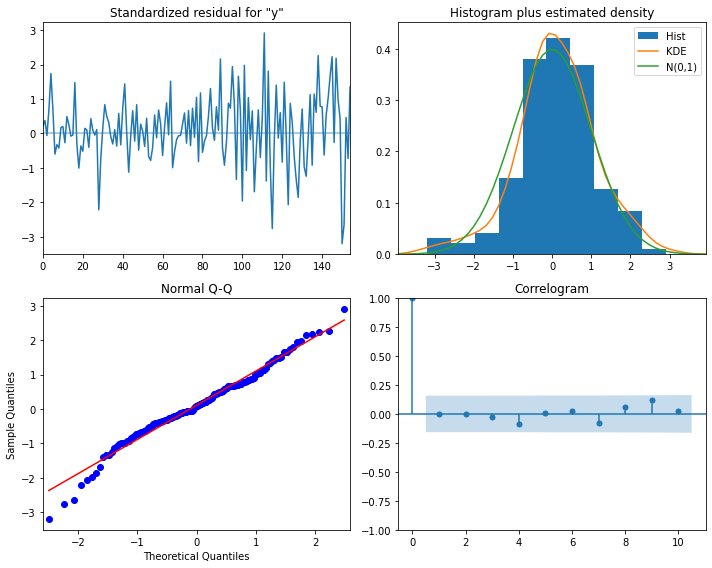

In [28]:
sarima_model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

In [29]:
# From the the top-left plot, the variance is not constant, which is a discrepancy in comparison to white noise. 
# At the top right is the distribution of the residuals, we can see what is close to a normal distribution. 
# The Q-Q plot displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. 
# Finally, the correlogram at the bottom right, shows no significant coefficient after lag 0.

# Thus, from a qualitative standpoint, our residuals are close to white noise, the model’s errors are random.

In [30]:
# Next run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated
from statsmodels.stats.diagnostic import acorr_ljungbox

pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)
pvalue.columns = ['stat', 'p-value']
pvalue

,stat,p-value
1,0.436870,0.508637
2,0.627573,0.730675
3,0.646083,0.885806
4,2.258451,0.688344
5,2.950675,0.707590
6,3.389643,0.758590
7,9.982342,0.189576
8,10.592297,0.225887
9,11.854318,0.221647
10,11.985632,0.286019


In [31]:
# p-value are all > 0..05, so we can conclude that the residuals are independent/ uncorrelated like white noise
# we now use it for forcasting

df_pred = pd.DataFrame(df['y'].iloc[-36:])
df_pred.head()

,y
168,15.829550
169,17.554701
170,18.100864
171,17.496668
172,19.347265


In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    
    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):            
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)            
            
        return pred_last_season    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(11,2,11))            
            res = model.fit(disp=False)            
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
        return pred_ARIMA
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)            
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
        return pred_SARIMA

In [33]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 12

# The naive seasonal forecast resuses the data from 2007 as a forecast for 2008
# df_pred['naive_seasonal'] = df['y'].iloc[180:192].values

pred_last_season = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')
pred_ARIMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')
pred_SARIMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

df_pred['last_season_pred'] = pred_last_season
df_pred['ARIMA_pred'] = pred_ARIMA
df_pred['SARIMA_pred'] = pred_SARIMA

df_pred.head()

,y,last_season_pred,ARIMA_pred,SARIMA_pred
168,15.829550,15.339097,16.653532,16.745827
169,17.554701,15.370764,16.401654,16.619347
170,18.100864,16.142005,17.741008,17.255308
171,17.496668,16.685754,17.269143,18.107505
172,19.347265,17.636728,18.167598,18.722189


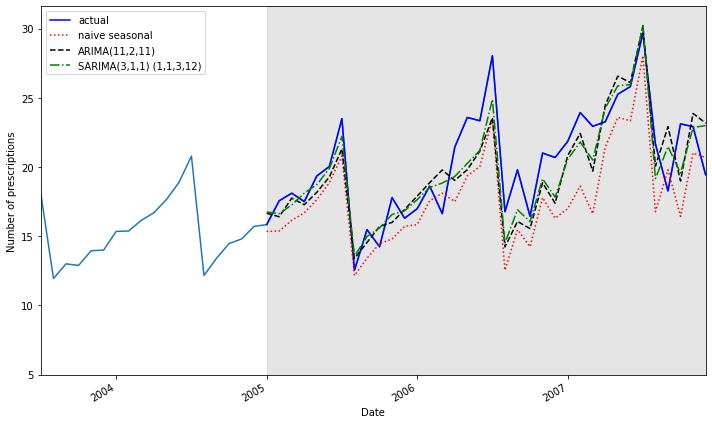

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df['ds'], df['y'])
ax.plot(df_pred['y'], 'b-', label='actual')
ax.plot(df_pred['last_season_pred'], 'r:', label='naive seasonal')
ax.plot(df_pred['ARIMA_pred'], 'k--', label='ARIMA(11,2,11)')
ax.plot(df_pred['SARIMA_pred'], 'g-.', label='SARIMA(3,1,1) (1,1,3,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of prescriptions')
ax.axvspan(168, 203, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 203, 12), np.arange(1991, 2008, 1))
ax.set_xlim(150, 203)
ax.set_ylim(5, )

fig.autofmt_xdate()
plt.tight_layout()

In [35]:
# function to compute the MAPE - Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
# Calculate MAPE
mape_naive_seasonal = mape(df_pred['y'], df_pred['last_season_pred'])
mape_ARIMA = mape(df_pred['y'], df_pred['ARIMA_pred'])
mape_SARIMA = mape(df_pred['y'], df_pred['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

12.686561923100614 9.099275375128977 7.56335260713372


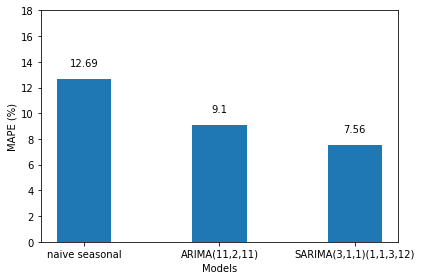

In [37]:
# Plot the MAPE
x = ['naive seasonal', 'ARIMA(11,2,11)', 'SARIMA(3,1,1)(1,1,3,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

fig, ax = plt.subplots()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 18)

# Display the MAPE as text in the bar plot
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    
plt.tight_layout()

In [38]:
# The SARIMA model has the lowest MAPE of all methods and is therefore the best-performing method for this situation

In [39]:
# Record end time

end = dt.now()
elapsed = end - start

print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:59:59
